In [1]:
import os
import numpy as np
import json
import cv2
import random
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor


In [2]:


def get_balloon_dicts(img_dir):
    """
    Obtiene las anotaciones de la base de datos

    Arguments:
    img_dir (string): Contiene el path del directorio raiz de la base de datos (que contiene las carpetas train y val)

    Returns:
    dataset_dicts (lista): lista que contiene anotaciones mencionadas por el archivo.json 
    """
    
    #Encuentra archivos JSON con el nombre "via_region_data.json" 
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    #Crea una lista llamada dataset dicts
    dataset_dicts = []

    """
    Para cada archivo JSON encontrado obtiene información de (filename,idx,height, width)(all_points_x, all_points_y
    y la guarda en la lista dicts.
    La estructura es:
    - Imagen
        - filename
        - idx
        - height
        - width
        - shape
        - All x,y points
    """
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("../../datasets/balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")


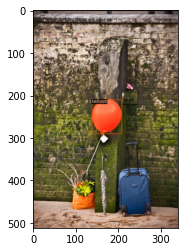

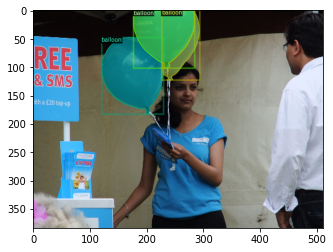

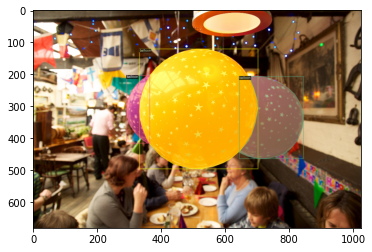

In [4]:
dataset_dicts = get_balloon_dicts("../../datasets/balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.show()

In [5]:
sys.path.append('/home/josmar/proyectos/centermask2')

from detectron2.engine import DefaultTrainer
from centermask.config import get_cfg
from detectron2.engine import  default_setup
from train_net import Trainer
import torch
cfg = get_cfg()
cfg.merge_from_file('/home/josmar/proyectos/centermask2/configs/centermask/centermask_V_39_eSE_FPN_ms_3x.yaml')
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = '/home/josmar/proyectos/centermask2/weights/centermask2-V-39-eSE-FPN-ms-3x.pth'  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.FCOS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.FCOS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

          )
          (concat): Sequential(
            (OSA2_1_concat/conv): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (OSA2_1_concat/norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
            (OSA2_1_concat/relu): ReLU(inplace=True)
          )
          (ese): eSEModule(
            (avg_pool): AdaptiveAvgPool2d(output_size=1)
            (fc): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
            (hsigmoid): Hsigmoid()
          )
        )
      )
      (stage3): _OSA_stage(
        (Pooling): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        (OSA3_1): _OSA_module(
          (layers): ModuleList(
            (0): Sequential(
              (OSA3_1_0/conv): Conv2d(256, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (OSA3_1_0/norm): FrozenBatchNorm2d(num_features=160, eps=1e-05)
              (OSA3_1_0/relu): ReLU(inplace=True)
            )
            (1): Sequentia

In [6]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.FCOS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.MODEL.FCOS.INFERENCE_TH_TEST = 0.7
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

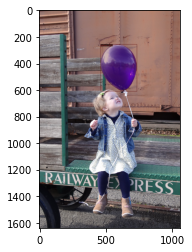

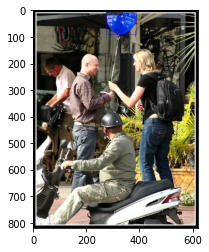

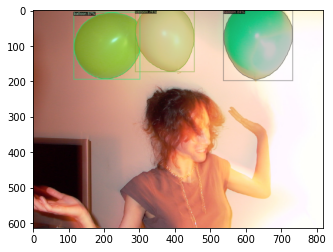

In [7]:
from detectron2.utils.visualizer import ColorMode
import cv2
import random
from detectron2.utils.visualizer import Visualizer


dataset_dicts = get_balloon_dicts("../../datasets/balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image())
    plt.show()
    name = "results/{}.jpg".format(d["image_id"])
    cv2.imwrite(name, out.get_image()[:, :, ::-1])
    

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [11/09 15:30:37 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[11/09 15:30:37 d2.evaluation.coco_evaluation]: 'balloon_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [11/09 15:30:37 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/balloon_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[11/09 15:30:38 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[11/09 15:30:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/09 15:30:38 d2.data.common]: Serializing 13 elements to byte tensors and concatenating the

OrderedDict([('bbox',
              {'AP': 79.39126961010751,
               'AP50': 88.73858857218238,
               'AP75': 85.0135770095179,
               'APs': 40.11881188118812,
               'APm': 62.178354037808745,
               'APl': 93.33001885086762}),
             ('segm',
              {'AP': 80.50138319891741,
               'AP50': 88.73858857218238,
               'AP75': 86.73185591642861,
               'APs': 13.491614467569207,
               'APm': 64.29405318463347,
               'APl': 94.81920192019203})])